BUILD A CONVOLUTIONAL NEURAL NETWORK (CNN) FOR IMAGE CLASSIFICATION USING ENSORFLOW OR PYTORCH
A convolutional neural network (CNN) consists of an input and an output layer, as well as multiple hidden layers. The hidden layers of a CNN typically consist of a series of convolutional layers that convolve with a multiplication or other dot product.

About the Dataset
This dataset contains 6,899 images from 8 distinct classes compiled from various sources. The classes include airplane, car, cat, dog, flower, fruit, motorbike and person.

1. Airplane images  
2. Car images
3. Cat images  
4. Dog images  
5. Flower images  
6. Fruit images  
7. Motorbike images  
8. Person images

Acknowledgements¶
Airplane images obtained from http://host.robots.ox.ac.uk/pascal/VOC
Car images obtained from https://ai.stanford.edu/~jkrause/cars/car_dataset.html
Cat images obtained from https://www.kaggle.com/c/dogs-vs-cats
Dog images obtained from https://www.kaggle.com/c/dogs-vs-cats
Flower images obtained from http://www.image-net.org
Fruit images obtained from https://www.kaggle.com/moltean/fruits
Motorbike images obtained from http://host.robots.ox.ac.uk/pascal/VOC
Person images obtained from http://www.briancbecker.com/blog/research/pubfig83-lfw-dataset

In [3]:
# Define
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib import image as mp_image
import seaborn as sns

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

In [1]:
import os
import zipfile
import torch
from google.colab import files
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Step 1: Upload your ZIP file containing the image dataset
print(" Upload your natural_images.zip file")
uploaded = files.upload()

# Step 2: Unzip the uploaded dataset
zip_path = 'natural_images.zip'
extract_path = '/content/natural_images'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



 Upload your natural_images.zip file


Saving natural_images.zip to natural_images.zip


In [2]:
# Step 3: Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Step 4: Load dataset using ImageFolder
#dataset = datasets.ImageFolder(root=extract_path, transform=transform)
#dataset = datasets.ImageFolder('natural_images', transform=transform)
dataset = datasets.ImageFolder(root='natural_images/natural_images', transform=transform)

# Now these should be class names like 'car', 'dog', etc.
classes = dataset.classes
print("Classes:", classes)

# Step 5: Split dataset into training and validation sets
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Step 6: Create DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Step 7: Show dataset details
print("Classes found:", dataset.classes)
images, labels = next(iter(train_loader))
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)

Classes: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Classes found: ['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']
Image batch shape: torch.Size([32, 3, 128, 128])
Label batch shape: torch.Size([32])


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import models

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Use pretrained ResNet18
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes=8):
        super(FineTunedResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize model, loss, optimizer
model = FineTunedResNet(num_classes=8).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


block executed


In [12]:
# Step 10: Train the Model with Validation
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_epoch_loss = val_loss / val_total
    val_epoch_acc = 100 * val_correct / val_total
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}% | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.2f}%")

# Step 11: Save the Model
torch.save(model.state_dict(), "resnet18_finetuned.pth")
print("\U0001F4BE Model saved as resnet18_finetuned.pth")


Epoch [1/10] Train Loss: 0.1309, Train Acc: 96.27% | Val Loss: 0.0349, Val Acc: 98.70%
Epoch [2/10] Train Loss: 0.0319, Train Acc: 99.06% | Val Loss: 0.0201, Val Acc: 99.35%
Epoch [3/10] Train Loss: 0.0182, Train Acc: 99.55% | Val Loss: 0.0289, Val Acc: 98.99%
Epoch [4/10] Train Loss: 0.0153, Train Acc: 99.47% | Val Loss: 0.0250, Val Acc: 99.20%
Epoch [5/10] Train Loss: 0.0121, Train Acc: 99.62% | Val Loss: 0.0183, Val Acc: 99.35%
Epoch [6/10] Train Loss: 0.0227, Train Acc: 99.42% | Val Loss: 0.0249, Val Acc: 99.28%
Epoch [7/10] Train Loss: 0.0189, Train Acc: 99.40% | Val Loss: 0.0329, Val Acc: 99.28%
Epoch [8/10] Train Loss: 0.0085, Train Acc: 99.75% | Val Loss: 0.0143, Val Acc: 99.57%
Epoch [9/10] Train Loss: 0.0079, Train Acc: 99.73% | Val Loss: 0.0321, Val Acc: 99.13%
Epoch [10/10] Train Loss: 0.0121, Train Acc: 99.57% | Val Loss: 0.0163, Val Acc: 99.35%
💾 Model saved as resnet18_finetuned.pth


In [13]:
from google.colab import files
files.download("resnet18_finetuned.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

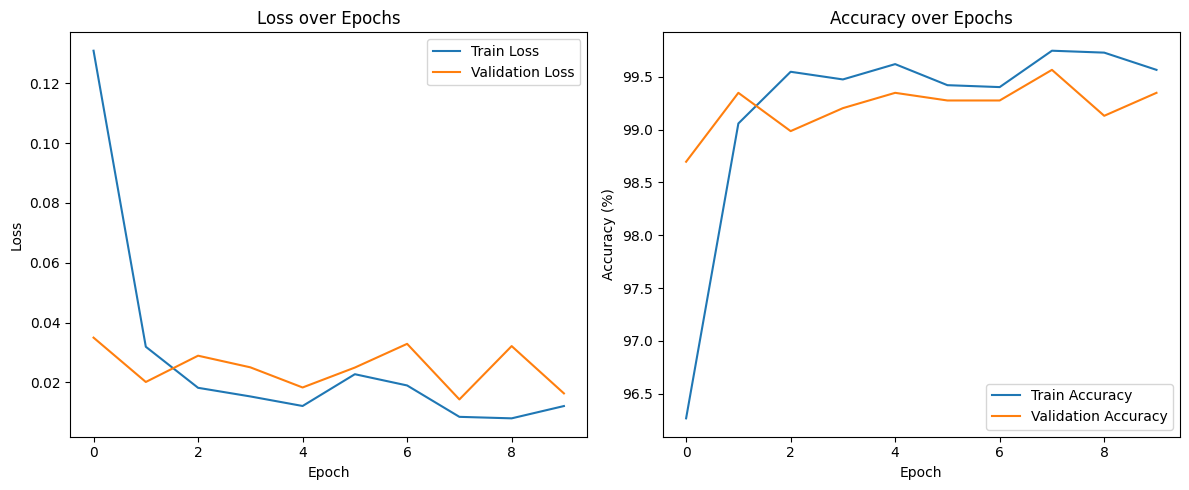

In [15]:
#training and validation metrics to better visualize performance
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot loss (train + val)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.legend()

# Plot accuracy (train + val)
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()



Corrected Evaluation Script (ResNet-compatible):


✅ Validation Accuracy: 99.13%

🎯 Ground Truth: ['cat', 'car', 'motorbike', 'motorbike', 'flower']
🤖 Predicted   : ['cat', 'car', 'motorbike', 'motorbike', 'flower']


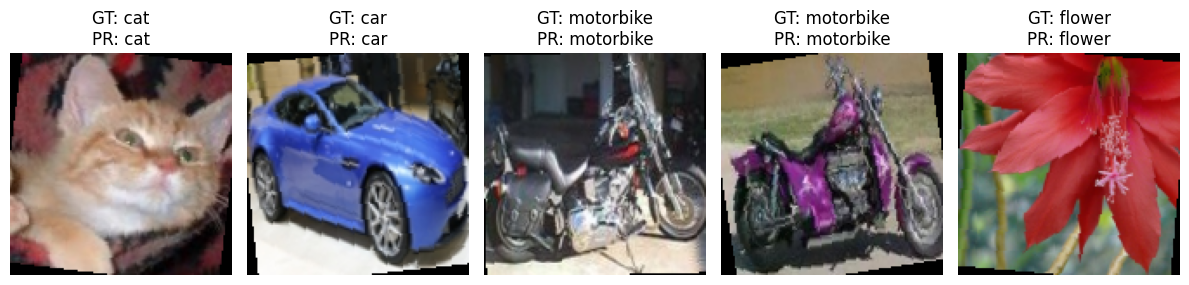

In [24]:
import torch
from torch import nn
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

# Use the same transform as training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Use the same val_dataset and class names from training
# Assuming this code is run in same session where val_dataset exists

# Reuse val_loader if still in memory; otherwise recreate:
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
class_names = dataset.classes  # Same class order as training
num_classes = len(class_names)

# ✅ Define the model class
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedResNet, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# ✅ Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FineTunedResNet(num_classes=num_classes).to(device)
model.load_state_dict(torch.load("resnet18_finetuned.pth", map_location=device))
model.eval()

# ✅ Evaluate on validation set
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"\n✅ Validation Accuracy: {accuracy:.2f}%")

# ✅ Show some predictions
def imshow(img, title=None):
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Show a few sample predictions
dataiter = iter(val_loader)
images, labels = next(dataiter)
images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print("\n🎯 Ground Truth:", [class_names[labels[j]] for j in range(min(5, len(labels)))])
print("🤖 Predicted   :", [class_names[predicted[j]] for j in range(min(5, len(predicted)))])

# Display images with predictions
plt.figure(figsize=(12, 6))
for i in range(min(5, len(images))):
    plt.subplot(1, 5, i + 1)
    imshow(images[i], title=f"GT: {class_names[labels[i]]}\nPR: {class_names[predicted[i]]}")
plt.tight_layout()
plt.show()


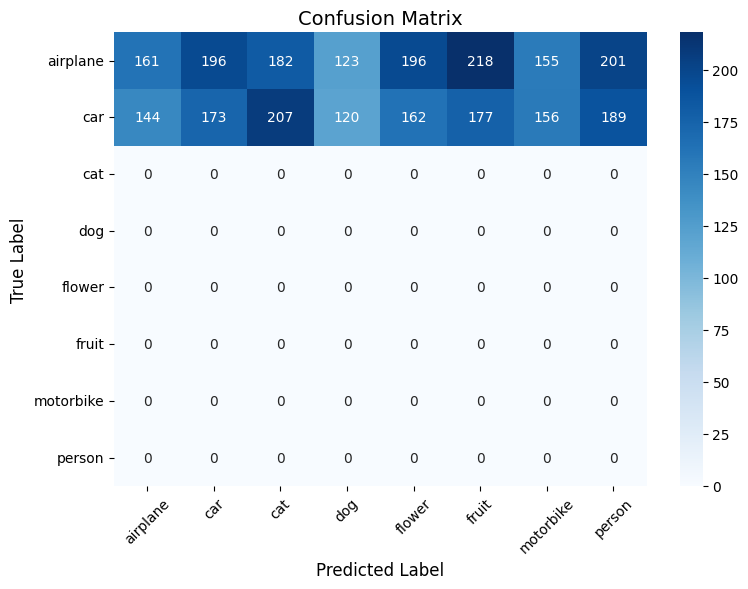

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Unique classes actually present in the labels/predictions
unique_classes = sorted(set(all_labels) | set(all_preds))

# Optional: map class indices to class names (if you have dataset.classes)
# Make sure only the used classes are included
display_classes = [dataset.classes[i] for i in unique_classes]

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=unique_classes)

# Create a DataFrame for better annotation
df_cm = pd.DataFrame(cm, index=display_classes, columns=display_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Extract Business Insights from the Model

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Predict on test data
true_labels = []
pred_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Class names from dataset
class_names = test_loader.dataset.classes

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)
report_text = classification_report(true_labels, pred_labels, target_names=class_names)
print(report_text)

# Extract insights
print("\n=== Business Insights ===")
low_perf_classes = []
confused_pairs = []

# Analyze class-wise performance
for cls, metrics in report.items():
    if isinstance(metrics, dict):
        precision, recall, f1 = metrics["precision"], metrics["recall"], metrics["f1-score"]
        if precision < 0.6 or recall < 0.6:
            print(f"- Class '{cls}' has low performance: Precision={precision:.2f}, Recall={recall:.2f}")
            low_perf_classes.append(cls)

# Find top confusion pairs
cm_np = np.array(cm)
np.fill_diagonal(cm_np, 0)  # remove correct predictions
top_confused = np.unravel_index(np.argsort(cm_np.ravel())[-3:], cm_np.shape)  # top 3 confused
for i in range(len(top_confused[0])):
    actual = top_confused[0][i]
    predicted = top_confused[1][i]
    if cm_np[actual, predicted] > 0:
        confused_pairs.append((class_names[actual], class_names[predicted], cm_np[actual, predicted]))
        print(f"- Frequently confused: Actual '{class_names[actual]}' predicted as '{class_names[predicted]}' ({cm_np[actual, predicted]} times)")

# Business Recommendations
print("\n=== Business Recommendations ===")
if low_perf_classes:
    print("- Consider collecting more training data or applying augmentation for low-performing classes:", ', '.join(low_perf_classes))
if confused_pairs:
    print("- Introduce secondary checks for distinguishing between:", ', '.join([f"{a} ↔ {b}" for a, b, _ in confused_pairs]))
if not low_perf_classes and not confused_pairs:
    print("- Model performing well across classes. Consider deploying with confidence.")
